# Predicting AAPL stock price with an LSTM

In [57]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn

In [58]:
data = pd.read_csv("AAPL.csv")
data.head()

,Date,Close/Last,Volume,Open,High,Low
0,10/22/2024,$235.86,38846580,$233.885,$236.22,$232.60
1,10/21/2024,$236.48,36254470,$234.45,$236.85,$234.45
2,10/18/2024,$235.00,46431470,$236.18,$236.18,$234.01
3,10/17/2024,$232.15,32993810,$233.43,$233.85,$230.52
4,10/16/2024,$231.78,34082240,$231.60,$232.12,$229.84


In [59]:
data["Close/Last"] = [np.float32(val[1:]) for val in data["Close/Last"]]
data["Open"] = [np.float32(val[1:]) for val in data["Open"]]
data["High"] = [np.float32(val[1:]) for val in data["High"]]
data["Low"] = [np.float32(val[1:]) for val in data["Low"]]
data.head()

,Date,Close/Last,Volume,Open,High,Low
0,10/22/2024,235.860001,38846580,233.884995,236.220001,232.600006
1,10/21/2024,236.479996,36254470,234.449997,236.850006,234.449997
2,10/18/2024,235.000000,46431470,236.179993,236.179993,234.009995
3,10/17/2024,232.149994,32993810,233.429993,233.850006,230.520004
4,10/16/2024,231.779999,34082240,231.600006,232.119995,229.839996


In [60]:
data["Date"] = pd.to_datetime(data["Date"])
data.sort_values(by="Date", inplace=True)

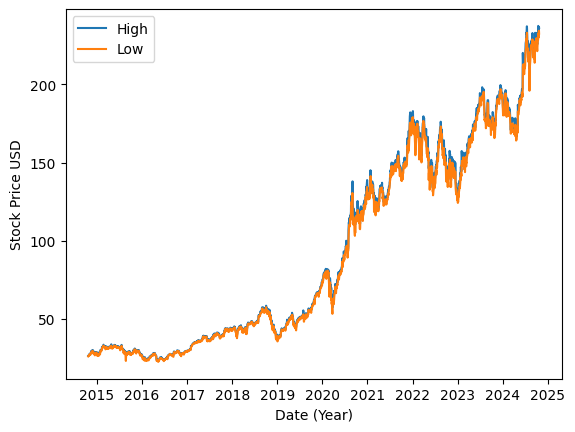

In [61]:
plt.plot(data["Date"], data["High"], label = "High")
plt.plot(data["Date"], data["Low"], label = "Low")
plt.xlabel("Date (Year)")
plt.ylabel("Stock Price USD")
plt.legend()

In [140]:
high = data["High"].to_numpy()

def create_dataset(window_size):
    X = []
    y = []
    for i in range(len(high)-window_size):
        X.append(high[i:i+window_size])
        y.append(high[i+window_size])
    return torch.tensor(X),torch.tensor(y)

window_size = 30
X, y = create_dataset(window_size)
X.shape, y.shape

(torch.Size([2486, 30]), torch.Size([2486]))

In [141]:
N = len(X)
X_train, y_train = X[:int(0.8*N)], y[:int(0.8*N)]
X_val, y_val = X[int(0.8*N):int(0.9*N)], y[int(0.8*N):int(0.9*N)]
X_test, y_test = X[int(0.9*N):], y[int(0.9*N):]
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

torch.Size([1988, 30]) torch.Size([1988])
torch.Size([249, 30]) torch.Size([249])
torch.Size([249, 30]) torch.Size([249])


In [155]:
n_hidden_lstm = 64
n_hidden_linear = 10
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(window_size, n_hidden_lstm, batch_first=True)
        self.l1 = nn.Linear(n_hidden_lstm, n_hidden_linear)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(n_hidden_linear, 1)
    def forward(self, x):
        x1, _ = self.lstm(x)
        x2 = self.l1(x1)
        x2 = self.relu(x2)
        x3 = self.l2(x2)
        return x3

In [156]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [158]:
EPOCHS = 100
BATCH_SIZE = 16

def train(X, y, epochs, batch_size):
    for epoch in range(epochs):
        mean_loss = 0
        count = 0
        for i in range(0, len(X), batch_size):
            predicted = model(X[i:i+batch_size])
            true_val = y[i:i+batch_size]
            predicted = predicted.squeeze()
            optimizer.zero_grad()
            loss = loss_fn(predicted, true_val)
            mean_loss += loss.item()
            count += 1
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | loss: {mean_loss}")
train(X_train, y_train, EPOCHS, BATCH_SIZE)

Epoch: 0 | loss: 315961.5318784714
Epoch: 10 | loss: 318494.013171196
Epoch: 20 | loss: 318357.7758512497
Epoch: 30 | loss: 318243.1001148224
Epoch: 40 | loss: 318187.0398874283
Epoch: 50 | loss: 318146.8404531479
Epoch: 60 | loss: 318111.2427330017
Epoch: 70 | loss: 318077.28089237213
Epoch: 80 | loss: 318044.46280002594
Epoch: 90 | loss: 318012.05450725555


In [159]:
predictions = model(X_train)
predictions = np.array(predictions.detach())
true_values = np.array(y_train)
predictions.shape

(1988, 1)

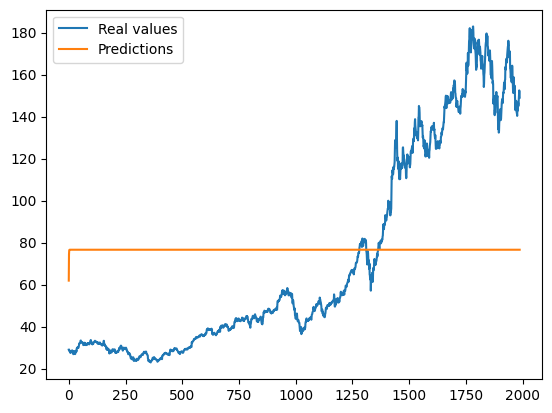

In [160]:
plt.plot(true_values, label = "Real values")
plt.plot(predictions, label = "Predictions")
plt.legend()

tensor([[26.2628, 26.3725, 26.3700, 26.6850, 26.8425],
        [26.3725, 26.3700, 26.6850, 26.8425, 26.8375],
        [26.3700, 26.6850, 26.8425, 26.8375, 27.0100],
        [26.6850, 26.8425, 26.8375, 27.0100, 27.5750],
        [26.8425, 26.8375, 27.0100, 27.5750, 27.3725],
        [26.8375, 27.0100, 27.5750, 27.3725, 27.3250],
        [27.0100, 27.5750, 27.3725, 27.3250, 27.1975],
        [27.5750, 27.3725, 27.3250, 27.1975, 27.3300],
        [27.3725, 27.3250, 27.1975, 27.3300, 27.3325],
        [27.3250, 27.1975, 27.3300, 27.3325, 27.4375]])